In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## **Task**

We want to train an MLP to learn the construction of names. To achieve this we want to maximise the likelihood of the $N$ names observed in the dataset:

$$
\max_{\theta} \sum_{i=1}^{N} \hat{p}(\mathbf{x}_i) = \max_{\theta} \sum_{i=1}^{N} \prod_{j=1}^{M_i} \hat{p}(x_j | x_{j-1}, x_{j-2}, x_{j-3}; \theta)
$$

In particular, we choose to break down the probability of a name into the product of the conditional probabilities of each character given a three-letter context window (we use '.' as the special token to pad the start and end of a name). For example, the name "John" would give us the following data points:

* ... $\rightarrow$ J
* ..J $\rightarrow$ o
* .Jo $\rightarrow$ h
* Joh $\rightarrow$ n
* ohn $\rightarrow$ .

We begin by constructing a training set of such data points from all the names in the dataset. We then use the negative log-likelihood of the data as the loss function to be minimized. See `mm_intro.ipynb` for more details.

# **Dataset**

In [2]:
# Load data
words = open('names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Create a dictionary that maps characters to integers and vice versa
char2idx = {c: i+1 for i, c in enumerate('abcdefghijklmnopqrstuvwxyz')}
char2idx['.'] = 0 # special character for marking start and end of a word
idx2char = {i: c for c, i in char2idx.items()}

In [5]:
# Form training pairs (context, target characters)
block_size = 3 # context size for next character prediction

def build_dataset(words):
    X, Y = [], []
    for word in words:
        w2idx = [0] * block_size + [char2idx[c] for c in word] + [0]
        for i in range(len(w2idx) - block_size):
            X.append(w2idx[i:i+block_size])
            Y.append(w2idx[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape, X.dtype, Y.dtype)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train, Y_train = build_dataset(words[:n1]) # 80% of words
X_val, Y_val = build_dataset(words[n1:n2]) # 10% of words
X_test, Y_test = build_dataset(words[n2:]) # 10% of words

# print first 10 samples of X_train and Y_train
# for i in range(len(Y_train[:10])):
#     print(''.join([idx2char[idx.item()] for idx in X_train[i]]), '->', idx2char[Y_train[i].item()])

torch.Size([182580, 3]) torch.Size([182580]) torch.int64 torch.int64
torch.Size([22767, 3]) torch.Size([22767]) torch.int64 torch.int64
torch.Size([22799, 3]) torch.Size([22799]) torch.int64 torch.int64


# **MLP**

We will use a simple MLP with an embedding layer for the input (shared across all characters), one hidden layer, and a softmax output layer. The approach is similar to the one used in the paper [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

1. **Embedding Layer**: As done in `mm_intro.ipynb`, characters are represented as one-hot vectors and passed through an embedding layer to obtain a dense representation. Regarding the implementation, we observe that a matrix multiplication of one-hot vectors with an embedding matrix is equivalent to a lookup in the embedding matrix. This can be implemented using simple indexing operations in PyTorch which is a lot more efficient than matrix multiplication: `emb = C[X]`.
2. **Hidden Layer**: The hidden layer is a fully connected layer with weights and biases. The input to the hidden layer is the concatenation of the embeddings of the three characters in the context window. To perform this concatenation, we use the `view` function in PyTorch which is extremely efficient as it doesn't directly manipulate the data in memory but simply changes its interpretation. 
3. **Output Layer**: The output layer is a fully connected layer with weights and biases. The output of the hidden layer is passed through this layer to obtain the logits for each character in the vocabulary. 
4. **Loss**: Instead of manually implementing the softmax and cross-entropy loss to compute the negative log-likelihood from the logits as we did in `mm_intro.ipynb`, we use PyTorch's `torch.nn.functional.cross_entropy` function which combines the two operations into one and is numerically not only more stable but also more efficient in the forward and backward passes. This is because the softmax and cross-entropy operations are fused into a single kernel and computed together. For more info, refer to the [YoutTube video](https://youtu.be/TCH_1BHY58I?t=1968) associated with this tutorial.

Note that when implementing models in PyTorch, it's always important to double-check the shapes of the tensors at each step using a small batch of data to make sure that the operations are being performed as intended.

In [6]:
# Hyperparameters
emb_dim = 2 # embedding dimension
h1_dim = 100 # hidden layer dimension

# For reproducibility
g = torch.Generator().manual_seed(2147483647)

# Embedding layer
C = torch.randn((27, 10), requires_grad=True, generator=g) # shape: (vocab_size, emb_dim)
# Hidden layer
W1 = torch.randn((30, 200), requires_grad=True, generator=g) # shape: (block_size * emb_dim, h1_dim)
b1 = torch.randn((200), requires_grad=True, generator=g) # shape: (h1_dim)
# Output layer
W2 = torch.randn((200, 27), requires_grad=True, generator=g) # shape: (h1_dim, vocab_size)
b2 = torch.randn((27), requires_grad=True, generator=g) # shape: (vocab_size)

parameters = [C, W1, b1, W2, b2]
print('Number of parameters:', sum([p.numel() for p in parameters]))

Number of parameters: 11897


## Training

Once you have built your model it's good practice to check that it's working as expected by overfitting it on a small batch of data. This means that the model should be able to memorize the data and achieve a loss of 0. 

In our case, we overfit the model to the first five entries of our `words` dataset by rerunning the training set construction code above with `words[:5]`. We then train the model for 1000 epochs and observe that the loss does indeed decrease significantly (to $0.2535$). The reason, however, why we are not able to achieve a loss of $0$, despite having a relatively large model of $3481$ parameters for only five words (32 samples), is because in some cases there is more than one possible next character given the context window. For example, in the 32 samples, the context window "..." appears multiple times and is followed by different characters. Hence, there is some inherent ambiguity in the data which prevents the model from achieving a loss of $0$.

To compare the model's predictions with our labels `Y`, we can use the `torch.argmax` function along the first dimension of the `logits` to obtain the index of the character with the highest probability and compare the two.

### Learning Rate

When training a model, it's important to pick the right learning rate. If the learning rate is too small, the model will take a long time to converge. If the learning rate is too large, the model will diverge and the loss will increase. One simple approach to find the optimal learning rate is to test a range of learning rates and pick the one that achieves the lowest loss. In particular, we may choose to test $1000$ learning rates logarithmically over the range $[1\mathrm{e}{-3}, 1]$. For each learning rate we run a single batch of training and record the loss. We then plot the loss against the learning rate and pick the learning rate that achieves the lowest loss, `plt.plot(lr_i, loss_i)`. After training our model for a sufficient number of epochs at this optimal learning rate, we can additionally perform a _learning rate decay_ (e.g. $\times 0.1$) to potentially achieve an even lower loss.

In [7]:
# Stat tracking
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # log scale LRs over range [1e-3, 1]
lr_i = []
loss_i = []

In [11]:
batch_size = 32

# Training loop
for i in range(50000):
    # mini-batch sampling
    batch_idxs = torch.randperm(len(Y_train))[:batch_size]
  
    # forward pass
    emb = C[X_train[batch_idxs]] # shape: (#samples, block_size, emb_dim) 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # shape: (#samples, hidden_dim) 
    logits = h @ W2 + b2 # shape: (#samples, vocab_size)
    loss = F.cross_entropy(logits, Y_train[batch_idxs]) # shape: (1)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = 0.01 # during LR tuning, use lrs[i] instead
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    # lr_i.append(lre[i])
    loss_i.append(loss.log10().item())

# Plot loss vs. learning rate
# plt.plot(lr_i, loss_i)

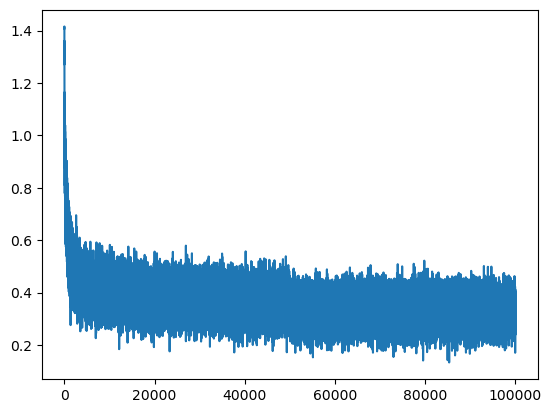

In [12]:
# A thick band of the loss curve indicates that our batch size may be too small, i.e. the gradients are too noisy.
plt.plot(loss_i)

## Validation

Once we have trained our model, we want to evaluate its performance on a validation set. In particular, we want to check that the model is not overfitting to the training set and that it is able to generalize to unseen data. To do this, we compute the loss on the validation set and compare it to the loss on the training set. If the loss on the validation set is significantly higher than the loss on the training set, then the model is overfitting. In this case, we may want to consider using a smaller model or adding regularization techniques such as dropout. However, if the loss on the validation set is similar to the loss on the training set, then the model is underfitting and can expect to achieve better performance by using a larger model.

The trick when adapting the model to these findings is to do it systematically. We may begin increasing the size of one layer and be aware of bottlenecks that may arise due to the size of the other layers not being large enough. We may also want to consider adding more layers to the model. In general, it's good practice to start with a small model and gradually increase its size until we start to see diminishing returns. In our case we started with an embedding size of $2$ per character and a hidden layer of size $100$. We then increased the embedding size to $10$ and the hidden layer size to $200$ to achieve a validation loss of $2.1983$ and a training loss of $2.1703$, when training for $50\text{k}$ steps with $\text{LR}{=}0.1$ and another $50\text{k}$ steps with $\text{LR}{=}0.01$. Batch size was $32$. At this point our model may be big enough where it's starting to overfit to the training set. 

In [13]:
# forward pass for validation / testing
def infer(X, Y):
    with torch.no_grad():
        emb = C[X] # shape: (#samples, block_size, emb_dim) 
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # shape: (#samples, hidden_dim) 
        logits = h @ W2 + b2 # shape: (#samples, vocab_size)
        loss = F.cross_entropy(logits, Y) # shape: (1)
        print('Loss:', loss.item())

infer(X_val, Y_val)
infer(X_train, Y_train)

Loss: 2.1983089447021484
Loss: 2.170368194580078


## Plot embeddings

We can plot the embeddings of the characters in our vocabulary to see if there are any interesting patterns. For example, we may observe that vowels are clustered together. Furthermore, some of the more rare letters such as 'q' form outliers. As characters that are clustered together have similar embeddings, they may be interchangeable in some contexts. For example, the names "John" and "Jahn" are both valid names and the model should be able to predict the next character correctly in both cases.

In [ ]:
# Currently only works for 2D embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), idx2char[i], ha="center", va="center", color="white")
plt.grid('minor')